# Setup

In [1]:
import os
import glob
import itertools as it

import cv2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from pylibdmtx.pylibdmtx import decode
from ultralytics import YOLO, settings
root_dir = os.getcwd().replace('\\notebooks', '')
settings.update({'datasets_dir': f'{root_dir}/data/processed/test', 'runs_dir': f'{root_dir}/yolo/runs'})

# Image printing/saving helper

In [2]:
def print_save_imgs(imgs, titles, eval):
    '''Organizes images into a grid and saves to figures folder'''

    fig, axs = plt.subplots(len(imgs), 1, figsize=(5, 10))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        axs[i].imshow(img)
        axs[i].set_title(title)
        axs[i].axis('off')

    fig.savefig(f'../figures/{eval}.png', bbox_inches='tight')

In [3]:
def save_images(imgs, titles, dir):
    '''Saves images with titles to given directory'''

    for img, title in zip(imgs, titles):
        cv2.imwrite(f'{dir}/{title}.png', img)

# Evaluation Functions

In [4]:
def eval_baseline(glob_path):
    '''
    Runs baseline decoder and counts the number of decodings
    '''
    img_paths = glob.glob(glob_path)

    # stat tracking
    num_decodings = 0
    num_valid_decodings = 0

    imgs = []
    titles = []

    failure_cases = []
    success_cases = []

    for img_path in img_paths:
        img = cv2.imread(img_path)

        decodings = decode(img, timeout=1000, max_count=1)

        actual_decoding = os.path.basename(img_path).split('_')[0]
        actual_decoding = actual_decoding.replace('-', '')

        # fixing some actual decodings
        if actual_decoding == 'KV8INMEP':
            actual_decoding = '#D1FPE50HA9NS0047XG264##KV8INMEP'
        elif actual_decoding == 'KW8PXY3D':
            actual_decoding = '#D1FPE50HA9NS0047XG264##KW8PXY3D'

        if decodings is not None and len(decodings) > 0:
            num_decodings += 1

            for decoding in decodings:
                decoded_string = decoding.data.decode('utf-8')

                if decoded_string == actual_decoding:
                    print(f'Valid decoding! {actual_decoding}')
                    num_valid_decodings += 1
                    imgs.append(img)
                    titles.append(actual_decoding)
                    success_cases.append((img, actual_decoding))
                    # print image
                    # plt.imshow(img)
                    # plt.axis('off')
                    # plt.show()
                else:
                    print('Invalid decoding!')
                    print(actual_decoding)
                    print(decoded_string)
        else: # no decodings
            failure_cases.append((img, actual_decoding))

    # calculate stats
    dm_decode_rate = num_decodings/len(img_paths)
    valid_decode_rate = num_valid_decodings/len(img_paths)

    # save stat images for later inspection
    save_images([img for img, _ in failure_cases], [title for _, title in failure_cases], '../data/stats/failures/baseline')
    save_images([img for img, _ in success_cases], [title for _, title in success_cases], '../data/stats/successes/baseline')

    print()
    print(f'{num_valid_decodings}/{len(img_paths)}')
    print(f'Dm decode rate: {dm_decode_rate}')
    print(f'Valid decode rate: {valid_decode_rate}')
    print_save_imgs(imgs, titles, 'baseline')

In [5]:
def eval_map(model, eval_yaml):
    '''
    Runs ultralytics val function to get mAP score and other metrics
    '''
    metrics = model.val(data=eval_yaml, split='test')

    print()
    print(f'Precision : {round(metrics.box.p[0], 2)}')  # close to 1 is good
    print(f'Recall    : {round(metrics.box.r[0], 2)}')  # close to 1 is good
    print(f'F1        : {round(metrics.box.f1[0], 2)}') # close to 1 is good
    print(f'mAP50-95  : {round(metrics.box.map, 3)}')   # 0.3 can be good, higher is better

In [6]:
def crop_decoding(model, glob_path, fig_title):
    '''
    Performs cropping and decoding of the images
    '''
    img_paths = glob.glob(glob_path)

    # stat tracking
    num_decodings = 0
    num_valid_decodings = 0

    imgs = []
    titles = []

    idx = 0
    for img_path in img_paths:
        img = cv2.imread(img_path)
        results = model(img, verbose=False)
        boxes = results[0].boxes.xyxy.tolist()

        actual_decoding = os.path.basename(img_path).split('_')[0]
        actual_decoding = actual_decoding.replace('-', '') # minor cleaning

        # fixing some actual decodings
        if actual_decoding == 'KV8INMEP':
            actual_decoding = '#D1FPE50HA9NS0047XG264##KV8INMEP'
        elif actual_decoding == 'KW8PXY3D':
            actual_decoding = '#D1FPE50HA9NS0047XG264##KW8PXY3D'

        if boxes != None and len(boxes) > 0:
            # only look at box with highest confidence
            box = boxes[0]

            # crop with some padding (to not have too small of a crop)
            pad = 45
            crop_obj = img[max(0, int(box[1])-pad):max(0, int(box[3])+pad), max(0, int(box[0])-pad):max(0, int(box[2])+pad)]
            decodings = decode(crop_obj, timeout=1000, max_count=1)

            if decodings != None and len(decodings) > 0:
                num_decodings += 1

                for decoding in decodings:
                    decoded_string = decoding.data.decode('utf-8')
                    
                    if decoded_string == actual_decoding:
                        print(f'Valid decoding! {actual_decoding}')
                        num_valid_decodings += 1
                        imgs.append(crop_obj)
                        titles.append(actual_decoding)
                        # print cropped image
                        plt.imshow(crop_obj)
                        plt.axis('off')
                        plt.show()
                    else:
                        print('Invalid decoding!')
                        print(actual_decoding)
                        print(decoded_string)

            # optional saving
            cv2.imwrite(f'../data/cropped/{actual_decoding}-{idx}.jpg', crop_obj)
            idx += 1

    # calculate stats
    dm_decode_rate = num_decodings/len(img_paths)
    valid_decode_rate = num_valid_decodings/len(img_paths)

    print()
    print(f'{num_valid_decodings}/{len(img_paths)}')
    print(f'Dm decode rate: {dm_decode_rate}')
    print(f'Valid decode rate: {valid_decode_rate}')
    print_save_imgs(imgs, titles, fig_title)

In [7]:
def eval_yolo(model_path, glob_path, eval_yaml, fig_title):
    '''
    Given a yolo model, makes the following evaluations:
     - mAP scores for bounding boxes
     - DM decode rate (% of decodings of test images)
     - Valid DM decode rate (% of decodings of test images that match with the serial number)
    Also prints the first "print_count" images with predictions.
    '''
    # Load the model
    model = YOLO(model_path)

    # mAP scores (saves to runs dir)
    # eval_map(model, eval_yaml)

    # Crop and decode
    crop_decoding(model, glob_path, fig_title)

# Stat eval

For running statistics on the .csv files saved under ../data/stats

In [8]:
def calc_stats(csv_path):

    # Load the csv
    df = pd.read_csv(csv_path,
                     usecols=['Case', 'Code Color', 'Background Color', 'Type', 'distortions'],
                     dtype={'Case': str, 'Code Color': str, 'Background Color': str, 'Type': str, 'distortions': str})

    # Calculate basic stats
    sns.set_theme()
    # sns.countplot(x='Code Color', data=df);plt.show()
    # sns.countplot(x='Background Color', data=df);plt.show()

    # Count of common color combinations
    df['Color Combo'] = df['Code Color'] + ' ' + df['Background Color']
    sns.countplot(x='Color Combo', data=df);plt.show()
    sns.countplot(x='Type', data=df);plt.show()

    # Count of distortions
    distortions = df['distortions'].unique().tolist()
    distortions.remove(np.nan)

    unique_distortions = {}
    for distortion in distortions:
        split = distortion.split(';')
        for s in split:
            if s not in unique_distortions:
                unique_distortions[s] = 1
            else:
                unique_distortions[s] += 1

    distortion_cols = {}
    for distortion in unique_distortions:
        distortion_cols[distortion] = []
    for _, row in df.iterrows():
        distortions = row['distortions']
        if pd.isna(distortions):
            for distortion in distortion_cols:
                distortion_cols[distortion].append(0)
            continue
        split = distortions.split(';')
        for distortion in distortion_cols:
            if distortion in split:
                distortion_cols[distortion].append(1)
            else:
                distortion_cols[distortion].append(0)
    for distortion in distortion_cols:
        df[distortion] = distortion_cols[distortion]

    sorted_ = df[distortion_cols.keys()].sum().sort_values(ascending=False)
    sns.barplot(x=sorted_, y=sorted_.keys());plt.xlabel('Count');plt.ylabel('');plt.show()

# Baseline

Valid decoding! 250115190210016


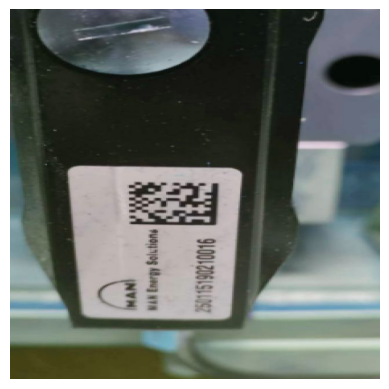

Valid decoding! 4F1K99136940006


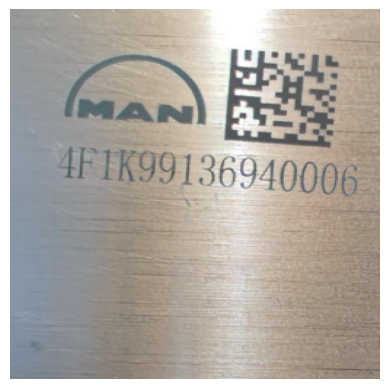

Valid decoding! 4F1K99136940007


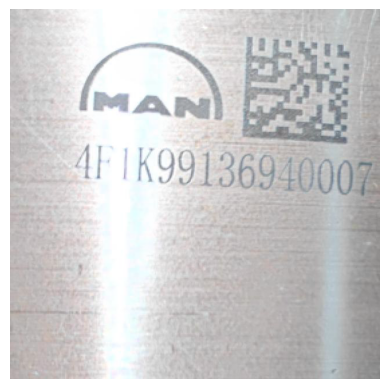

Valid decoding! #D1FPE50HA9NS0047XG264##KV8INMEP


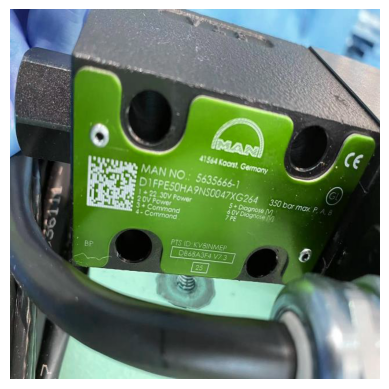

Valid decoding! #D1FPE50HA9NS0047XG264##KW8PXY3D


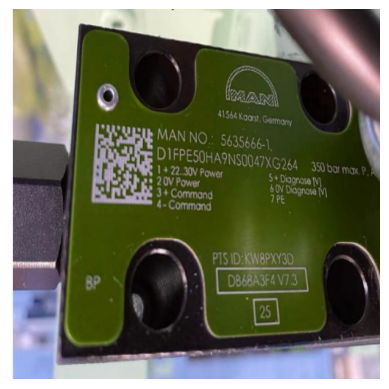


5/50
Dm decode rate: 0.1
Valid decode rate: 0.1


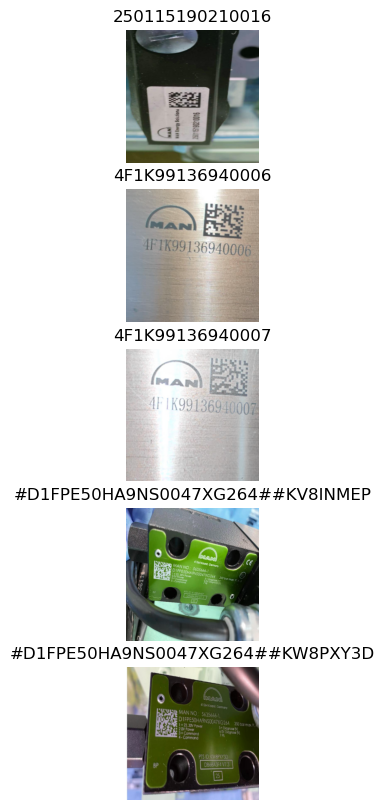

In [14]:
eval_baseline('../data/MAN/images/test/*.jpg')

In [ ]:
calc_stats('../data/stats/baseline.csv')

## Kaggle from Scratch

Valid decoding! 250115190210016


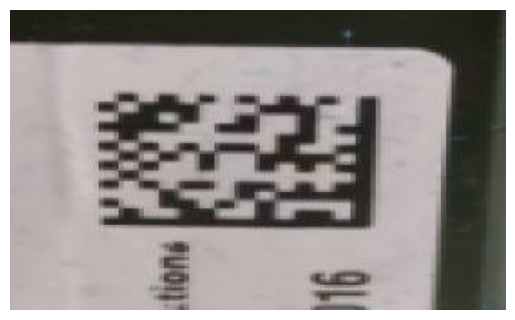

Valid decoding! 4F1K99136940006


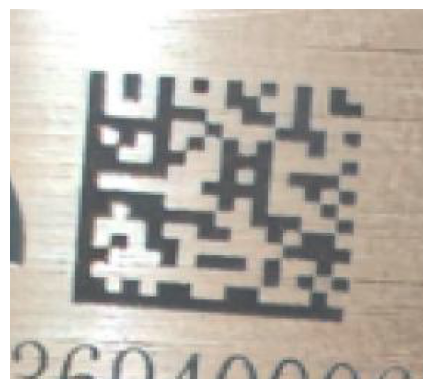


2/50
Dm decode rate: 0.04
Valid decode rate: 0.04


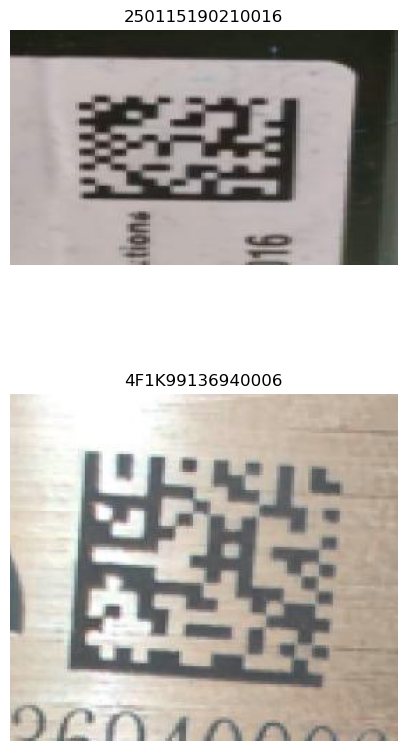

In [16]:
eval_yolo('../yolo/models/kaggle_scratch.pt', '../data/MAN/images/test/*.jpg', '../data/MAN/data.yaml', 'Kaggle Scratch')

## Kaggle finetuned

Valid decoding! 250115190210016


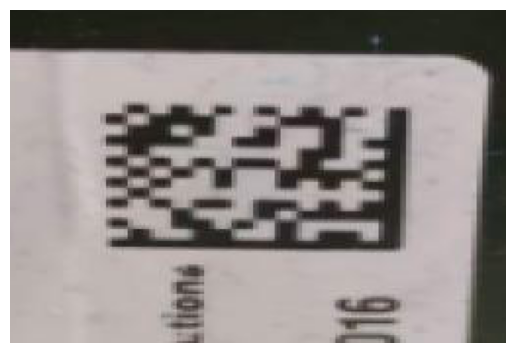

Valid decoding! 4F1K99136940006


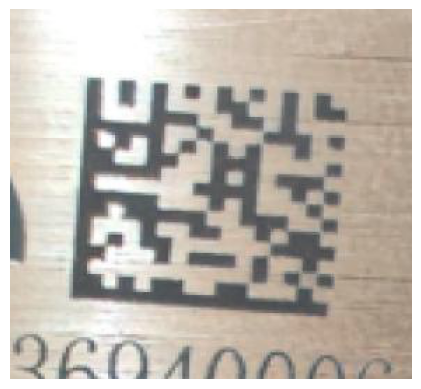

Valid decoding! 4F1K99136940007


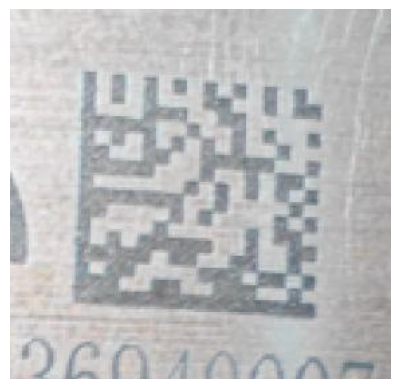

Valid decoding! #D1FPE50HA9NS0047XG264##KV8INMEP


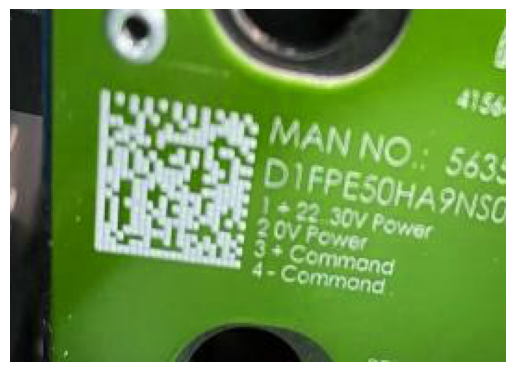

Valid decoding! #D1FPE50HA9NS0047XG264##KW8PXY3D


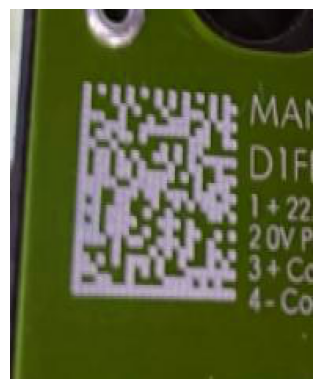


5/50
Dm decode rate: 0.1
Valid decode rate: 0.1


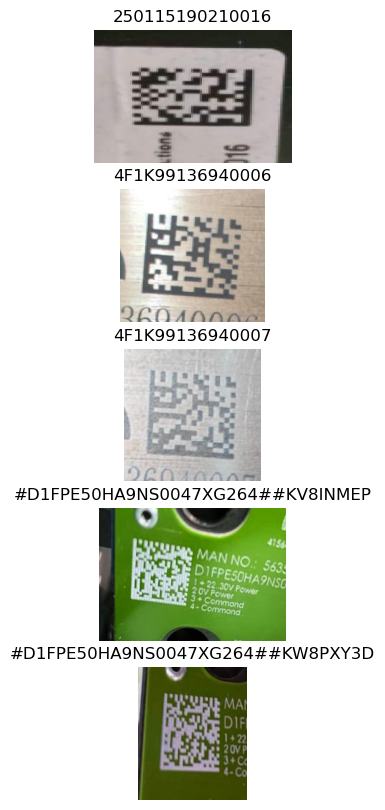

In [17]:
eval_yolo('../yolo/models/kaggle_finetuned.pt', '../data/MAN/images/test/*.jpg', '../data/MAN/data.yaml', 'Kaggle Finetuned')

## Ultralytics finetuned

Valid decoding! 250115190210016


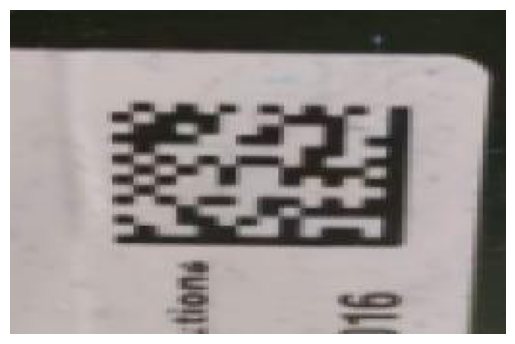

Valid decoding! 4F1K99136940006


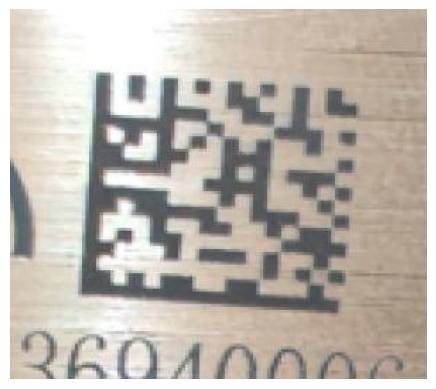

Valid decoding! 4F1K99136940007


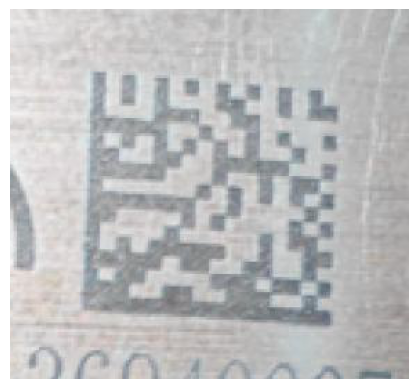

Valid decoding! #D1FPE50HA9NS0047XG264##KV8INMEP


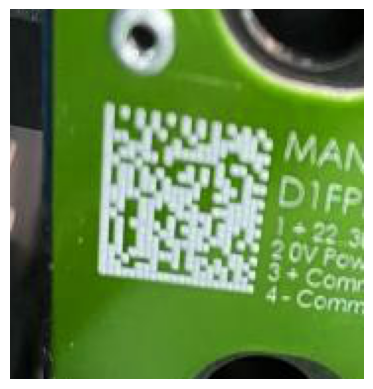

Valid decoding! #D1FPE50HA9NS0047XG264##KW8PXY3D


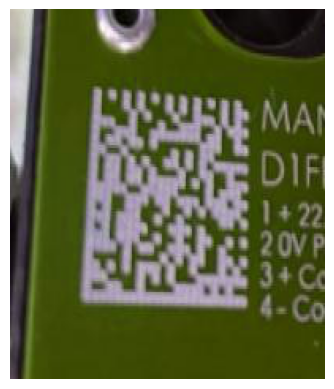


5/50
Dm decode rate: 0.1
Valid decode rate: 0.1


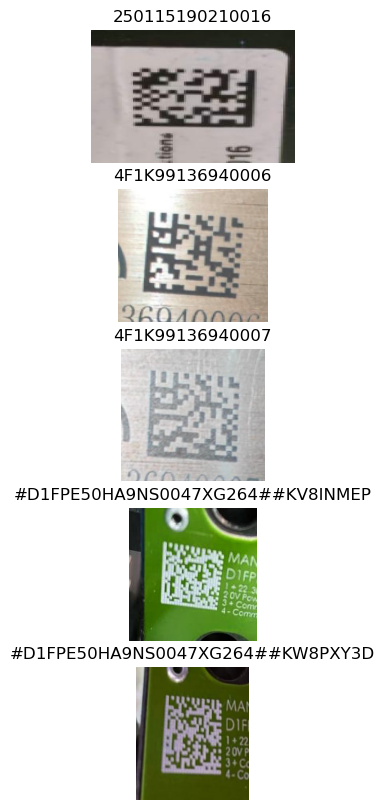

In [18]:
eval_yolo('../yolo/models/ultralytics_finetuned.pt', '../data/MAN/images/test/*.jpg', '../data/MAN/data.yaml', 'Ultralytics Finetuned')